<a href="https://colab.research.google.com/github/john-reilly/RoboFarm/blob/master/RoboRecycling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive

drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#if google colab base_dir is one thing else another
base_dir = '/content/gdrive/My Drive/RoboRecycling/'

In [0]:

#Requirements
#!keras==2.0.8


In [0]:
import os
import random
import time

import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps

# Find more models here
# https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md
# for Ref How to Retrain here, too much to do today....
# https://www.tensorflow.org/hub/tutorials/image_retraining
# the definitivee tutorial from Tensorflow
# https://github.com/tiangolo/tensorflow-models/blob/master/research/object_detection/object_detection_tutorial.ipynb
# the COCO categories are here
# https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/

class ObjectDetector:

    def __init__(self,location_path = base_dir, graph_filename = 'model/frozen.pb' ):       
        self.detection_graph = tf.Graph()
        with self.detection_graph.as_default():
            od_graph_def = tf.GraphDef()
            try:
                with tf.gfile.GFile( location_path + graph_filename, 'rb') as fid:
                    serialized_graph = fid.read()
                    od_graph_def.ParseFromString(serialized_graph)
                    tf.import_graph_def(od_graph_def, name='')
                    self.session = tf.Session(graph=self.detection_graph)
            except Exception as e:
                print(e)
                exit()


    def run_inference_for_single_image(self, image, show_stats = True ):
        # Get handles to input and output tensors
        ops = self.detection_graph.get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in ['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes']:
            tensor_name = key + ':0'
            if tensor_name in all_tensor_names:
                tensor_dict[key] = self.detection_graph.get_tensor_by_name(tensor_name)
        image_tensor = self.detection_graph.get_tensor_by_name('image_tensor:0') #indentation?





        # Run inference
        start = time.time()
        output_dict = self.session.run(tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)})
        elapsed = time.time() - start
        #print('inference took:', elapsed, ' seconds') 
        
        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]

        if show_stats == True:
          print('inference took:', elapsed, ' seconds') 
          print("num_detections:" , output_dict['num_detections'])
          print("Detection Classes: " , output_dict['detection_classes'])
          print("Detection Scores: " , output_dict['detection_scores'])

        return output_dict

    def overlay_bounding_boxes(self, image, output_dict,detection_class, probability_level, draw_boxes = False):
        classes = output_dict['detection_classes']
        boxes = output_dict['detection_boxes']
        scores = output_dict['detection_scores']

        height, width, _ = image.shape

        tf_boxes = []
        output_images = []
        for i in range(len(boxes)):
            confidence = float(scores[i])
            ymin, xmin, ymax, xmax = tuple(boxes[i].tolist())
            ymin = int(ymin * height)
            ymax = int(ymax * height)
            xmin = int(xmin * width)
            xmax = int(xmax * width)
            box_width = xmax - xmin
            box_height = ymax - ymin
            if box_width > 0:
              box_ratio = float(box_height) / box_width 
            #filter criteria
            if confidence >= probability_level and \
              classes[i] == detection_class :
                # also possible and \  #box_ratio >= 0.75     #box_width > 21   #box_height > 20
                #draw rectanlge around object having this here interferes with later on as cropped images have rectanlge over writes
                if draw_boxes:
                  cv2.rectangle(image, (xmin,ymin) , (xmax, ymax) , (255,0,0) ,2)
                #record object data
                tf_boxes.append(boxes[i])
                #crop object out of image for further processing
                crop_image = image[ymin:ymax, xmin:xmax]
                crop_output_image = Image.fromarray(crop_image)
                output_images.append(crop_output_image)
                
        return image, tf_boxes , output_images# <------your version might not need to return all 3



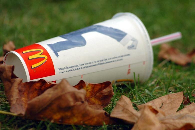

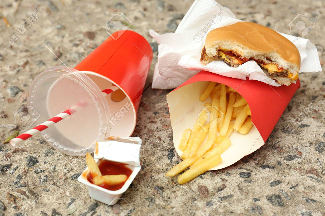

inference took: 3.35809326171875  seconds
num_detections: 100
Detection Classes:  [44  1 65  1 28  1 44 34  1  1  1  7 56 65 65 56 44  1  1 56  1  1 65  1
 65  1 56  1 56 28  1 56 65 75  1 56 28  1 44 56 62  1 44 56 56  1 56  3
 56 56 56 56  1 62 62 88  1  1  1  1 62 42 33  1 65  1 28 28  1 44 65 56
 62  1  1 62 56 56 56  1 67  1  1 56 64 28 65  3  1  1 36 44 34 84 56  1
  1 62 56 56]
Detection Scores:  [0.14545855 0.12371987 0.09233177 0.08282876 0.0811958  0.07519519
 0.07297057 0.06961766 0.06908047 0.06334561 0.05894479 0.05810872
 0.05774483 0.05627018 0.05323842 0.05133393 0.05130097 0.05085668
 0.05076852 0.04751059 0.04532075 0.04528973 0.04526466 0.0438619
 0.04299158 0.04267892 0.04118237 0.03929862 0.03873211 0.03800771
 0.03772351 0.03742588 0.03691259 0.03671986 0.03621686 0.03471005
 0.03431067 0.03421676 0.03417432 0.03370708 0.0336439  0.03337389
 0.03322259 0.03305826 0.03296405 0.03295124 0.03250214 0.03183332
 0.03183082 0.03151056 0.03124604 0.03109819 0.03107446 0.

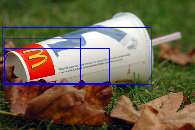

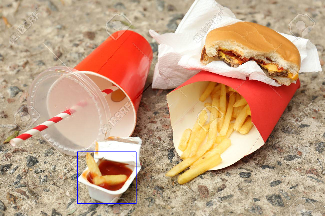

In [9]:

from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from keras.preprocessing.image import array_to_img, img_to_array, load_img


clip1 = VideoFileClip(base_dir + 'Test_Video/' + 'APPLE_VIDEO.MP4')
frame = clip1.get_frame(19)#3) #19


#test_image_1 = load_img(base_dir + 'Test_Images/' + 'fast_food_1.jpg' )
#test_image_1 = cv2.imread(base_dir + 'Test_Images/' + 'fast_food_1.jpg' )
#test_image_2 = cv2.imread(base_dir + 'Test_Images/' + 'fast_food_2.jpg' )
test_image_1 = mpimg.imread( base_dir + 'Test_Images/' + 'fast_food_1.jpg' )
test_image_2 = mpimg.imread( base_dir + 'Test_Images/' + 'fast_food_2.jpg' )

#test_image_1 = mpimg.imread( base_dir + 'Test_Images/' + 'straw.jpg' )
#test_image_2 = mpimg.imread( base_dir + 'Test_Images/' + 'straw_cup.jpg' )



#test_image_1 = img_to_array(test_image_1)
#test_image_2 = img_to_array(test_image_2)

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
test_image_1 = cv2.cvtColor(test_image_1, cv2.COLOR_BGR2RGB)
test_image_2 = cv2.cvtColor(test_image_2, cv2.COLOR_BGR2RGB)

#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
cv2_imshow( cv2.resize(test_image_1, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
cv2_imshow( cv2.resize(test_image_2, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


#my_detector = ObjectDetector(base_dir , 'model/frozen_RCNN_V2.pb')
#my_detector = ObjectDetector(base_dir , 'model/frozen_inference_graph.pb')
#my_detector = ObjectDetector(base_dir , 'model/frozen_resnet_fpn.pb')
#my_detector = ObjectDetector(base_dir , 'model/resnet_fpn.pb') #this one didn't work not frozen?
my_detector = ObjectDetector(base_dir , 'model/frozen_COCO.pb')
#output_dict = my_detector.run_inference_for_single_image(frame, show_stats = True)# False) # True)
output_dict_1 = my_detector.run_inference_for_single_image(test_image_1, show_stats = True)# False) # True)
output_dict_2 = my_detector.run_inference_for_single_image(test_image_2, show_stats = True)# False) # True)

#leave this colour change out
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
#test_image_1 = cv2.cvtColor(test_image_1, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
#test_image_2 = cv2.cvtColor(test_image_2, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?

#final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.80, draw_boxes = True)#False ) #True)
final_image_1, object_data_1, object_images_1  = my_detector.overlay_bounding_boxes( test_image_1, output_dict_1,44, 0.05, draw_boxes = True)#False ) #True)
final_image_2, object_data_2, object_images_2  = my_detector.overlay_bounding_boxes( test_image_2, output_dict_2,47, 0.05, draw_boxes = True)#False ) #True)
#After processing
#cv2_imshow(final_image)
#cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

#final_image_1 = cv2.cvtColor(final_image_1, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
#final_image_2 = cv2.cvtColor(final_image_2, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?

cv2_imshow( cv2.resize(final_image_1, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )
cv2_imshow( cv2.resize(final_image_2, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

In [10]:
#TRAIN.py
# Load the data

import gzip
import re
import os

import numpy as np
import pandas as pd
from time import time
from PIL import Image, ImageOps

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.backend import tensorflow_backend as ktf
from pathlib import Path

from os import listdir
from os.path import isfile, join


cup_type = ['recyclable_cup', 'not_recyclable_cup','UNKNOWN'] #add more categories?
categories = [[1,0,0], [0,1,0] ,[0,0,1]] 



def read_images(images_path): #not sure I need this
    labels = []
    features = []
    for root, dirs, files in os.walk(images_path, topdown=False):
        
        path = os.path.dirname(images_path + 'images_resized/')
        Path(path).mkdir(exist_ok=True)
        
        for filename in files:
            added = False
        
            for index, color in enumerate(cup_type):              
                labels.append(categories[index])
                
                img = load_img(images_path + cup_type[index]+ '/' + filename)
                img = crop_image(img)
                img.save('{}{}{}'.format(RESIZED_DIR,  cup_type[index]+ '/' ,filename), 'JPEG')
                x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) 
                features.append(x)
                added = True
                break
            if not added:
                print('Error invalid filename:', filename)

    return np.array(features), np.array(labels)

def preprocess_images(images_path):
  
    if not os.path.exists(images_path + 'preprocessed/'  ):
      os.makedirs(images_path + 'preprocessed/' )
  
    for root, dirs, files in os.walk(images_path, topdown=True):    
      for filename in files:
        img = load_img(images_path +  filename)
        img = crop_image(img)
        img.save(images_path + 'preprocessed' + filename)#this might go into preprocessed??



def load_prepared_images(images_path):
  
  features = []
  labels = []

  for root, dirs, files in os.walk(images_path, topdown=True):    
    for filename in files:
      img = load_img(images_path +  filename)
      x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150) #john 32*32 ?
      features.append(x)
      #labels.append(categories[0])
      labels.append(dirs) #will this work??
           

  return np.array(features), np.array(labels)


def remove_ext(filename):
    return re.sub(r'\.png|\.jpeg|\.jpg', '', filename, re.IGNORECASE)

def crop_image(img):
    img.thumbnail((32, 32), Image.ANTIALIAS)
    width, height = img.size
    delta_w = 32 - width
    delta_h = 32 - height
    padding = (delta_w // 2, delta_h // 2, delta_w - (delta_w // 2), delta_h - (delta_h // 2))
    img = ImageOps.expand(img, padding, fill=0)  # fill with black dots
    return img



features, labels = load_prepared_images(base_dir +  'preprocessed/')#check this

train = {}
test = {}

train['features'], test['features'], train['labels'], test['labels'] = train_test_split(features, labels, test_size=0.05)

# explore the data

print('# of training images:', train['features'].shape[0])
print('# of test images:', test['features'].shape[0])

# plot training data
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
print(dataframe_train_labels)

# Split training data into training and validation
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

print(features.shape)
print(labels.shape)

print("Updated Image Shape: {}".format(train['features'][0].shape))

model = Sequential()

model.add(layers.Lambda(lambda x: x/255.0 - 0.5, input_shape=(32,32,3))) # added

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=2, activation = 'softmax')) #for 2 categories

model.summary()

model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit(train['features'], train['labels'], epochs=52, validation_split=0.3, shuffle=True, callbacks=[tensorboard])


score = model.evaluate(test['features'], test['labels'])
print('Test loss:', score[0])
print('Test accuracy:', score[1])

model.save(base_dir + 'apple_lenet_model.h5')

# more examples here 
#https://www.tensorflow.org/tutorials/keras/classification
'''
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])
'''

# another short model
# https://developer.ibm.com/articles/image-recognition-challenge-with-tensorflow-and-keras-pt1/

# Setting up the layers.
'''
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100)),
        keras.layers.Dense(128, activation=tf.nn.sigmoid),
        keras.layers.Dense(16, activation=tf.nn.sigmoid),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
'''

ValueError: ignored

In [0]:
#classify.py

import numpy as np
from keras.models import load_model
from keras.preprocessing.image import img_to_array, load_img
import time
import os



from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


class ObjectClassifier:

    def __init__(self,location_path = base_dir, model_name = 'apple_lenet_model.h5' ):   #<-----change    
  
            try:
              self.class_model = load_model(base_dir + 'apple_lenet_model.h5')#<-----change 
              
            except Exception as e:
                print(e)
                exit()

            self.traffic_light_colors = ['ripe', 'not_ripe']

    def predict(self,image_name):

        img = load_img(image_name, False, target_size=(32, 32))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = selfclass_model.predict_proba(x)

        return preds[0], prob[0]

    def predict_for_detected(self, image_name):
      
        resized_image = image_name.resize((32,32), resample=0)

        x = img_to_array(resized_image)
        x = np.expand_dims(x, axis=0)
        preds = self.class_model.predict_classes(x)
        prob = self.class_model.predict_proba(x)

        return preds[0], prob[0]

    def draw_positive_boxes(self,final_image,object_data, object_images, show_each_addition =  False ):

      height, width ,_ = final_image.shape #  as per PIL
      print('final_image.shape : ', final_image.shape)


      for   i in  range(0, len(object_images ) ) :
        start = time.time()
        pred, prob = self.predict_for_detected( object_images[i]) #originally self was not here then it gave trouble for no reason

        #plt.imshow(object_images[i])
        #plt.show()
        elapsed = time.time() - start
        print('Result: ', ':', self.traffic_light_colors[pred], '- prodb:', prob, '-elapsed time:', elapsed, ' s')

        if pred == 0 :
          ymin, xmin, ymax, xmax = tuple(object_data[i].tolist())#tuple(boxes[i].tolist())
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)
          ymin = int(ymin * height)
          ymax = int(ymax * height)
          xmin = int(xmin * width)
          xmax = int(xmax * width)
          #print('ymin, xmin, ymax, xmax', ymin, xmin, ymax, xmax)

          cv2.rectangle(final_image, (int(xmin),int(ymin)) , (int(xmax),int( ymax) ) , (255,0,0) ,2)
          if show_each_addition  :
            cv2_imshow(final_image)
            

          #return final_image # <-------------wrong indentation caused return only if apple sucessfully calssified

      return final_image





In [0]:
#the complete pipeline


from google.colab.patches import cv2_imshow
from moviepy.editor import VideoFileClip
from IPython.display import HTML #from my lane line project
import cv2

#clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4')
#frame = clip1.get_frame(3)#3) #19

#Before processing
#frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#cv2_imshow( cv2.resize(frame, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )


my_detector = ObjectDetector(base_dir , 'frozen_inference_graph.pb')
my_classifier = ObjectClassifier(base_dir ,'apple_lenet_model.h5'  )


#pipeline


def pipeline(frame) :
  output_dict = my_detector.run_inference_for_single_image(frame, show_stats = False) # True)
  #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)#is rgb getting screwed up?
  final_image, object_data, object_images  = my_detector.overlay_bounding_boxes( frame, output_dict,53, 0.10, draw_boxes = False ) #True)
  #After processing
  #cv2_imshow(final_image)
  #cv2_imshow( cv2.resize(final_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) )

  last_image = my_classifier.draw_positive_boxes(final_image, object_data,object_images)
  

  #cv2_imshow( cv2.resize(last_image, None, fx = 0.25 , fy = 0.25, interpolation = cv2.INTER_CUBIC) ) #fails here if no image or objects?
  
  return last_image #forgot this!!

clip1 = VideoFileClip(base_dir + 'APPLE_VIDEO.MP4').subclip(0,5)
output_clip = clip1.fl_image(pipeline)
output_clip.write_videofile(base_dir + 'output_clip_4.mp4', audio = False)